In [1]:
from google.colab import drive


drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/My Drive/Colab Notebooks/project_paylocity/ashrae-energy-prediction

/content/gdrive/My Drive/Colab Notebooks/project_paylocity/ashrae-energy-prediction


In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import Counter
import datetime
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import tqdm

from sklearn.metrics import mean_squared_log_error
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train_preprocessed_may = pd.read_csv('train_preprocessed_may.csv')

In [5]:
train_2 = train_preprocessed_may[train_preprocessed_may['site_id'].isin([12,11])]

In [6]:
train_2["timestamp"] = pd.to_datetime(train_2["timestamp"])
train_2["hour"] = train_2["timestamp"].dt.hour
train_2["day"] = train_2["timestamp"].dt.day
train_2["weekend"] = train_2["timestamp"].dt.weekday
train_2["month"] = train_2["timestamp"].dt.month

train_2 = train_2.reset_index()
train_2 = train_2.drop(columns = ['index'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [7]:
def features_engineering1(df):
    
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove unimp Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)

    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [8]:
train_final = train_2.head(int(len(train_2)*(90/100)))
test_final = train_2[len(train_final):]

In [9]:
train_df = features_engineering1(train_final)
Y = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
features['building_id'].nunique()

41

In [13]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1200,
    "learning_rate": 0.01,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = Y.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = Y.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.29125	valid_1's rmse: 1.35232
[50]	training's rmse: 1.04984	valid_1's rmse: 1.1143
[75]	training's rmse: 0.865982	valid_1's rmse: 0.939142
[100]	training's rmse: 0.716802	valid_1's rmse: 0.800954
[125]	training's rmse: 0.601283	valid_1's rmse: 0.701303
[150]	training's rmse: 0.518659	valid_1's rmse: 0.634413
[175]	training's rmse: 0.453581	valid_1's rmse: 0.587891
[200]	training's rmse: 0.400948	valid_1's rmse: 0.553403
[225]	training's rmse: 0.364392	valid_1's rmse: 0.532527
[250]	training's rmse: 0.33309	valid_1's rmse: 0.515714
[275]	training's rmse: 0.308839	valid_1's rmse: 0.50464
[300]	training's rmse: 0.289722	valid_1's rmse: 0.496146
[325]	training's rmse: 0.273735	valid_1's rmse: 0.490397
[350]	training's rmse: 0.261713	valid_1's rmse: 0.486893
[375]	training's rmse: 0.251904	valid_1's rmse: 0.485198
[400]	training's rmse: 0.243394	valid_1's rmse: 0.484195
[425]	training's rmse: 0.236098	vali

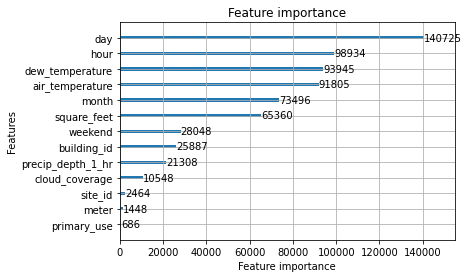

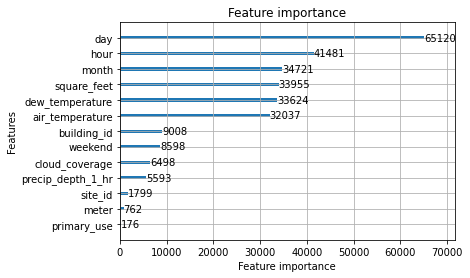

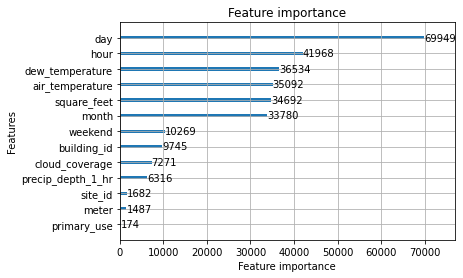

In [14]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [15]:
test_df = features_engineering1(test_final)
Y_test = (test_df["meter_reading"])
features_test = test_df.drop('meter_reading', axis = 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
evaluation1 = mean_squared_log_error(results, Y_test.values)
print(evaluation1)

0.7617059916877322


In [19]:
def features_engineering2(df):
    
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove unimp Columns
    drop = ["timestamp","year_built"]
    df = df.drop(drop, axis=1)



    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [20]:
train_df = features_engineering2(train_final)
Y = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1200,
    "learning_rate": 0.01,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = Y.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = Y.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.29378	valid_1's rmse: 1.35793
[50]	training's rmse: 1.05162	valid_1's rmse: 1.11902
[75]	training's rmse: 0.866432	valid_1's rmse: 0.943023
[100]	training's rmse: 0.727993	valid_1's rmse: 0.815877
[125]	training's rmse: 0.615078	valid_1's rmse: 0.720026
[150]	training's rmse: 0.525073	valid_1's rmse: 0.647487
[175]	training's rmse: 0.459706	valid_1's rmse: 0.599772
[200]	training's rmse: 0.404484	valid_1's rmse: 0.562458
[225]	training's rmse: 0.360443	valid_1's rmse: 0.536083
[250]	training's rmse: 0.328182	valid_1's rmse: 0.519332
[275]	training's rmse: 0.302692	valid_1's rmse: 0.507544
[300]	training's rmse: 0.281932	valid_1's rmse: 0.498922
[325]	training's rmse: 0.267014	valid_1's rmse: 0.493698
[350]	training's rmse: 0.253364	valid_1's rmse: 0.489516
[375]	training's rmse: 0.242856	valid_1's rmse: 0.487035
[400]	training's rmse: 0.233701	valid_1's rmse: 0.485413
[425]	training's rmse: 0.226133	v

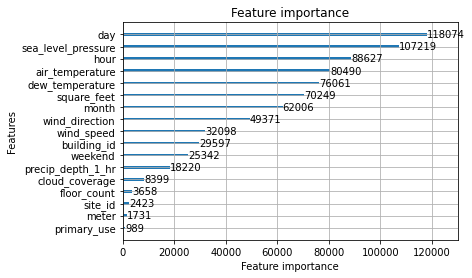

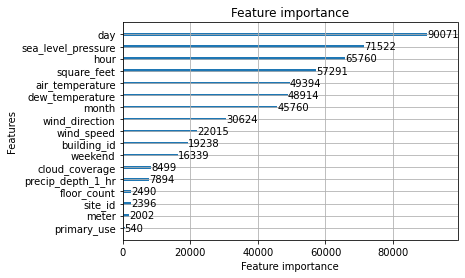

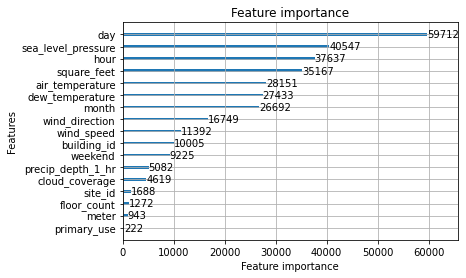

In [22]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [23]:
test_df = features_engineering2(test_final)
Y_test = (test_df["meter_reading"])
features_test = test_df.drop('meter_reading', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
evaluation1 = mean_squared_log_error(results, Y_test.values)
print(evaluation1)

0.7475283229815134


In [26]:
#we can now use autocorrelation and moving average; maybe seasonality as well for future prediction

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t

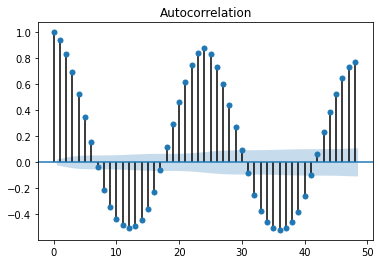

In [28]:
plot_acf(train_final[(train_final['building_id']==1029) & (train_final['meter']==0)]['meter_reading'].values, lags=48)
plt.show()

In [29]:
#can see clear autocorrelation as mean moves away from centre

In [30]:
def add_lags(df, window=3):
    group_df = df.groupby(['building_id','site_id'])
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        df[f'{col}_mean_lag{window}'] = lag_mean[col]
        df[f'{col}_max_lag{window}'] = lag_max[col]
        df[f'{col}_min_lag{window}'] = lag_min[col]
        df[f'{col}_std_lag{window}'] = lag_std[col]

In [31]:
add_lags(train_final, window = 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [32]:
def features_engineering3(df):
    
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df['square_feet'] =  np.log1p(df['square_feet'])


    
    # Remove unimp Columns
    drop = ["timestamp"]
    df = df.drop(drop, axis=1)

    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [33]:
train_df = features_engineering3(train_final)
Y = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [34]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1200,
    "learning_rate": 0.01,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = Y.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = Y.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.29075	valid_1's rmse: 1.35484
[50]	training's rmse: 1.0616	valid_1's rmse: 1.12928
[75]	training's rmse: 0.866837	valid_1's rmse: 0.942429
[100]	training's rmse: 0.720255	valid_1's rmse: 0.810068
[125]	training's rmse: 0.60129	valid_1's rmse: 0.70777
[150]	training's rmse: 0.517638	valid_1's rmse: 0.643152
[175]	training's rmse: 0.44665	valid_1's rmse: 0.591597
[200]	training's rmse: 0.392252	valid_1's rmse: 0.55614
[225]	training's rmse: 0.350882	valid_1's rmse: 0.532936
[250]	training's rmse: 0.320001	valid_1's rmse: 0.517173
[275]	training's rmse: 0.29368	valid_1's rmse: 0.504785
[300]	training's rmse: 0.273187	valid_1's rmse: 0.497043
[325]	training's rmse: 0.256879	valid_1's rmse: 0.492427
[350]	training's rmse: 0.24357	valid_1's rmse: 0.489141
[375]	training's rmse: 0.232352	valid_1's rmse: 0.487128
[400]	training's rmse: 0.222241	valid_1's rmse: 0.485842
[425]	training's rmse: 0.213843	valid_1'

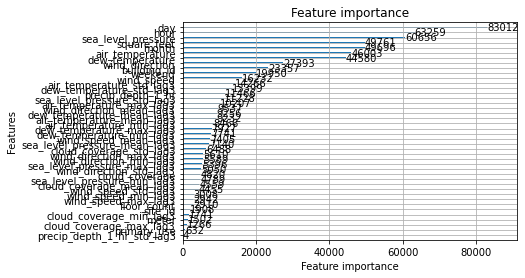

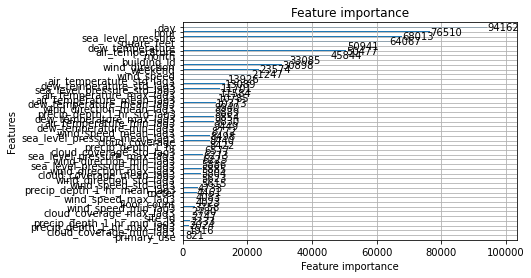

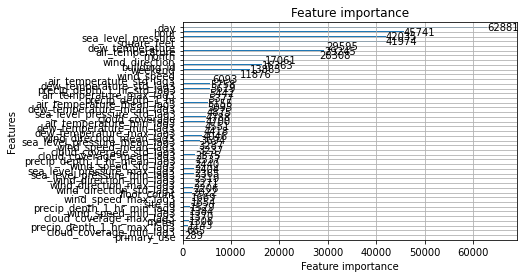

In [35]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [36]:
fi = pd.DataFrame([features.columns, models[0].feature_importance()]).T
fi.columns = ['feature', 'importance']
test_feature = fi.sort_values(by = 'importance').reset_index(drop='True')['feature'][-40:].values

In [37]:
add_lags(test_final, window = 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [38]:
test_df = features_engineering3(test_final)
Y_test = (test_df["meter_reading"])
features_test = test_df.drop('meter_reading', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [39]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
evaluation1 = mean_squared_log_error(results, Y_test.values)
print(evaluation1)

0.5771684093714078


In [44]:
def features_engineering4(df):
    
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    df['minute'] = df['timestamp'].dt.minute
    df['hourmin'] = df['hour']+(df['minute']/60)

    df['hourx'] = np.sin((360/24) * df['hourmin'])
    df['houry'] = np.cos((360/24) * df['hourmin'])
    df['dayx'] = np.sin((360/30) * df['day'])
    df['dayy'] = np.cos((360/30) * df['day'])

    df['monthx'] = np.sin((360/12) * df['month'])
    df['monthy'] = np.cos((360/12) * df['month'])
    
    # # Remove unimp Columns
    # drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count", "hour", "day", "month","minute","hourmin"]
    # df = df.drop(drop, axis=1)

    # Remove unimp Columns
    drop = ["timestamp","year_built"]
    df = df.drop(drop, axis=1)



   
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [45]:
train_df = features_engineering4(train_final)
Y = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [46]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1200,
    "learning_rate": 0.01,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = Y.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = Y.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.29604	valid_1's rmse: 1.37501
[50]	training's rmse: 1.05726	valid_1's rmse: 1.15315
[75]	training's rmse: 0.875047	valid_1's rmse: 0.996696
[100]	training's rmse: 0.725049	valid_1's rmse: 0.869785
[125]	training's rmse: 0.617468	valid_1's rmse: 0.788552
[150]	training's rmse: 0.525297	valid_1's rmse: 0.722914
[175]	training's rmse: 0.448526	valid_1's rmse: 0.670709
[200]	training's rmse: 0.392801	valid_1's rmse: 0.639171
[225]	training's rmse: 0.347269	valid_1's rmse: 0.614245
[250]	training's rmse: 0.314291	valid_1's rmse: 0.598689
[275]	training's rmse: 0.287679	valid_1's rmse: 0.587115
[300]	training's rmse: 0.267975	valid_1's rmse: 0.579882
[325]	training's rmse: 0.252276	valid_1's rmse: 0.574339
[350]	training's rmse: 0.239316	valid_1's rmse: 0.570088
[375]	training's rmse: 0.22892	valid_1's rmse: 0.567285
[400]	training's rmse: 0.219289	valid_1's rmse: 0.56562
[425]	training's rmse: 0.211427	val

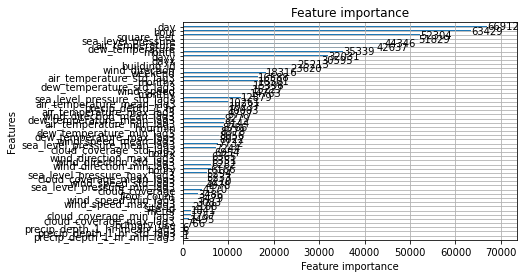

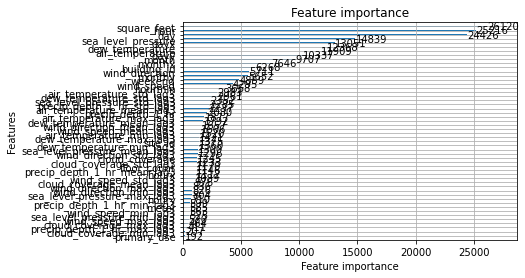

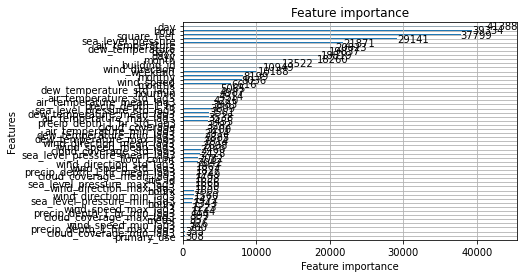

In [47]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [48]:
test_df = features_engineering4(test_final)
Y_test = (test_df["meter_reading"])
features_test = test_df.drop('meter_reading', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [49]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
evaluation1 = mean_squared_log_error(results, Y_test.values)
print(evaluation1)

0.8476211917036396
